In [22]:
import torch
import numba as nb
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings("ignore", category=NumbaWarning)

from scipy.optimize import minimize
from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

#### **Comparison of analytic vs torch Hessians**
Autograd Hessian is negative definite, analytic is not

In [2]:
nk = 500 * np.ones(2000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
from aeons.hessian import hess_autograd
H_autograd = hess_autograd(y, full, mean_X, covinv_X, theta_max)
cov_theta = np.linalg.inv(-H_autograd)
print(f'{H_autograd}')
print(f'eigvals: {np.linalg.eigvals(H_autograd)}') 

[[-2.24042334e+07  8.49409222e+03 -1.91724417e+07]
 [ 8.49409222e+03 -1.54944489e+02  4.13364078e+03]
 [-1.91724417e+07  4.13364078e+03 -1.64749260e+07]]
eigvals: [-3.88398832e+07 -3.94238018e+04 -7.34403768e+00]


/home/zixiao/Documents/III/project/aeons/aeons/hessian.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  return - torch.sum(log_abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)


In [3]:
from aeons.hessian import hess
H_analytic = hess(np.array(y), np.array(mean_X), np.array(covinv_X), theta_max)
print(f'{H_analytic}')
np.linalg.eigvals(H_analytic)

[[-2.24042334e+07  8.49409222e+03 -1.91724417e+07]
 [ 8.49409222e+03 -1.54944489e+02  4.13364078e+03]
 [-1.91724417e+07  4.13364078e+03 -1.64749260e+07]]


array([-3.88398832e+07, -3.94238018e+04, -7.34403769e+00])

In [4]:
%timeit H_autograd = hess_autograd(y, full, mean_X, covinv_X, theta_max)

23.8 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### **Observe errorbars vs true values for different X**

In [18]:
nk = 500 * np.ones(2000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
from aeons.hessian import hess_autograd
H_autograd = hess_autograd(y, full, mean_X, covinv_X, theta_max)
cov_theta = np.linalg.inv(-H_autograd)

In [52]:
minimise_bayes(y, full, mean_X, covinv_X, [2, 8, 1])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -301.71774726702756
             x: [ 1.031e+00  1.136e+01  9.701e-01]
           nit: 119
          nfev: 218
 final_simplex: (array([[ 1.031e+00,  1.136e+01,  9.701e-01],
                       [ 1.031e+00,  1.136e+01,  9.700e-01],
                       [ 1.031e+00,  1.136e+01,  9.700e-01],
                       [ 1.031e+00,  1.136e+01,  9.701e-01]]), array([-3.017e+02, -3.017e+02, -3.017e+02, -3.017e+02]))

In [33]:
minimise_bayes(y, full, mean_X, covinv_X, theta_true)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -302.44528091154734
             x: [ 1.068e+00  1.232e+01  9.380e-01]
           nit: 148
          nfev: 266
 final_simplex: (array([[ 1.068e+00,  1.232e+01,  9.380e-01],
                       [ 1.068e+00,  1.232e+01,  9.380e-01],
                       [ 1.068e+00,  1.232e+01,  9.380e-01],
                       [ 1.068e+00,  1.232e+01,  9.380e-01]]), array([-3.024e+02, -3.024e+02, -3.024e+02, -3.024e+02]))

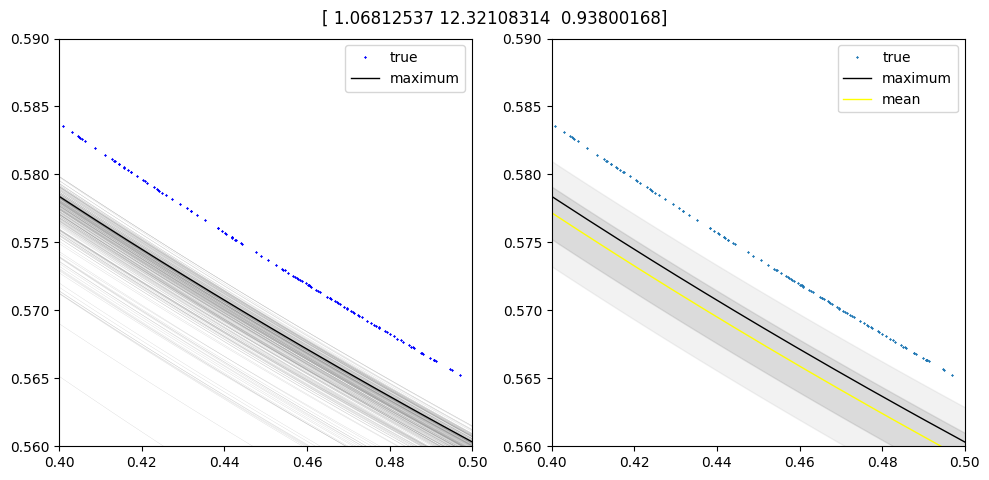

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
xlim = (0.4, 0.5)
ylim = (0.56, 0.59)
for i in range(200):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    ax1.plot(X_b, y, lw=.1, color='gray', alpha=.8)
ax1.plot(X, y, 'x', ms=1, color='blue', label='true')
ax1.plot(full.inverse(y, theta_max), y, lw=1, color='black', label='maximum')
ax1.legend();

samples = 1000
Xarrays = np.zeros((samples, len(y)))
for i in range(samples):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    Xarrays[i] = X_b
X_std = Xarrays.T.std(axis=1)
X_mean = Xarrays.T.mean(axis=1)

X_b = full.inverse(y, theta_max)
ax2.plot(X, y, 'x', ms=1, label='true')
ax2.plot(X_b, y, lw=1, color='black', label='maximum')
ax2.plot(X_mean, y, lw=1, color='yellow', label='mean')
ax2.fill_betweenx(y, X_mean - 2*X_std, X_mean + 2*X_std, color='gray', alpha=0.1)
ax2.fill_betweenx(y, X_mean - X_std, X_mean + X_std, color='gray', alpha=0.2)
ax2.legend();

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

plt.suptitle(theta_max, y=.95)
plt.tight_layout()

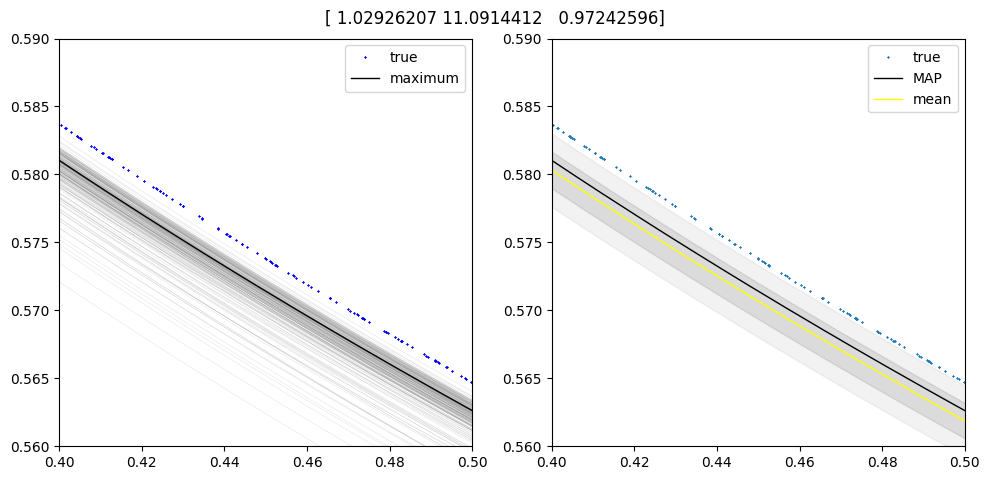

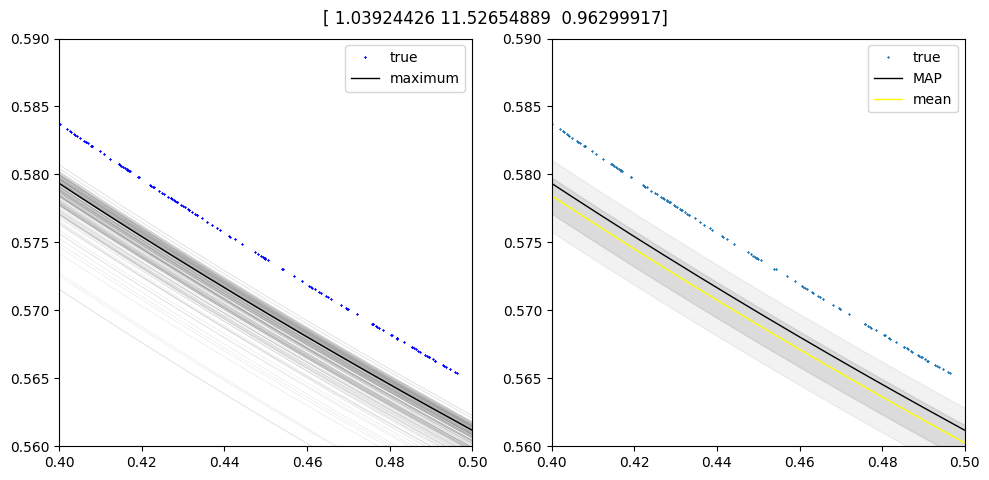

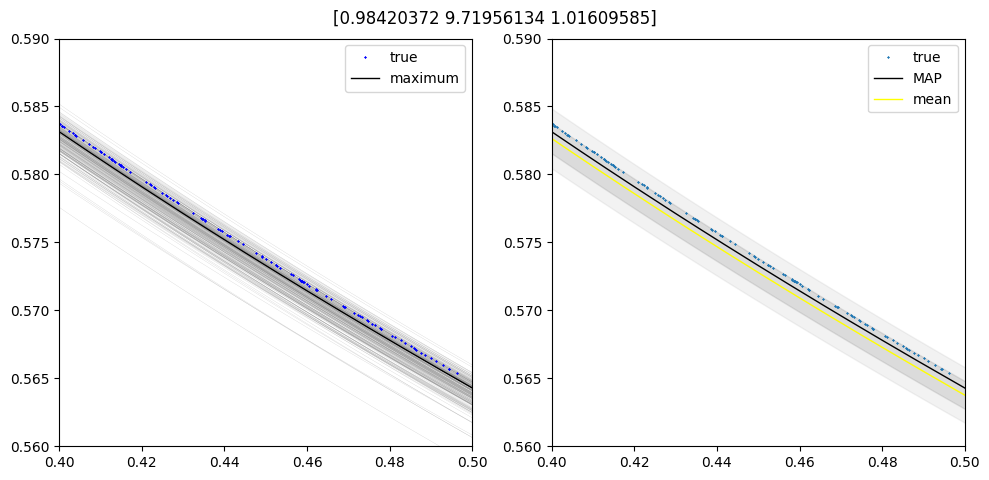

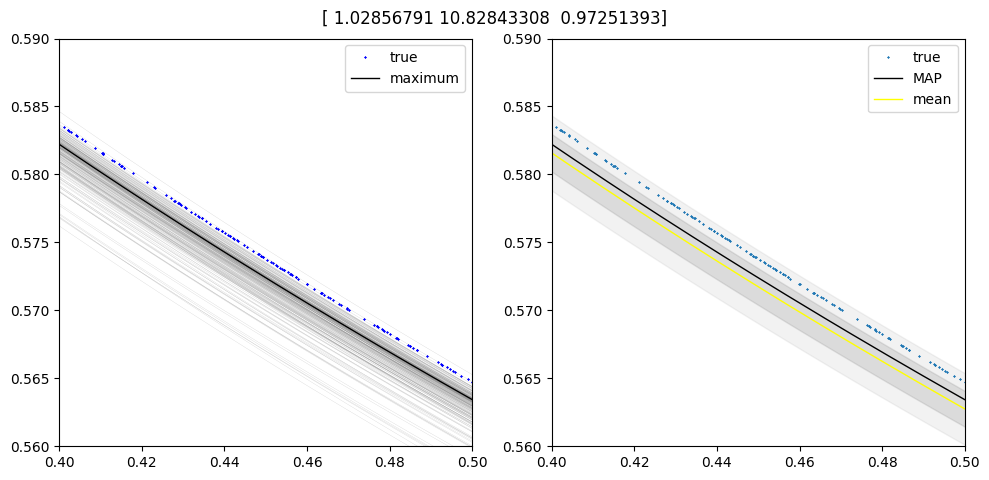

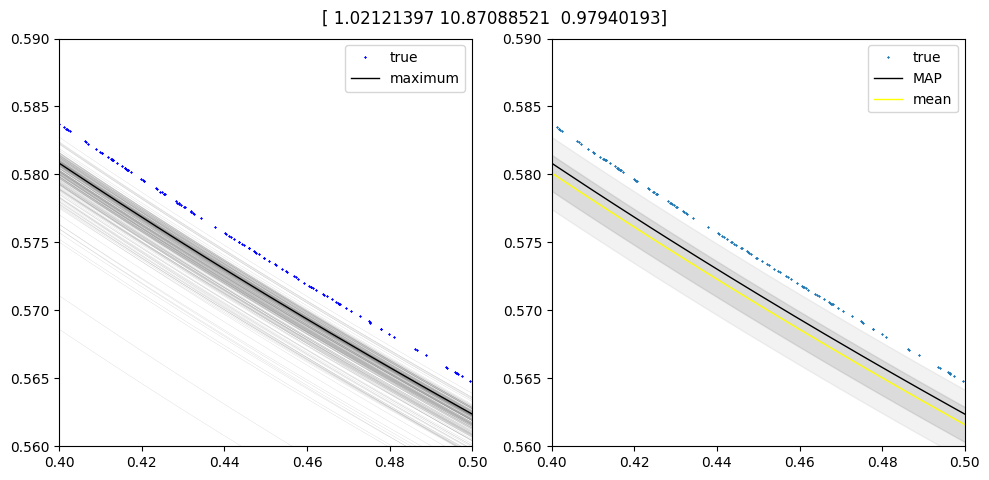

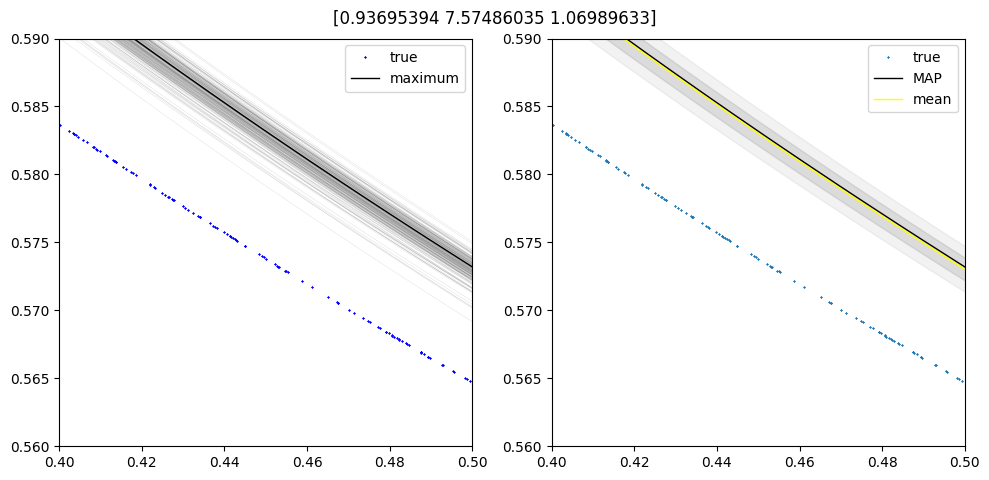

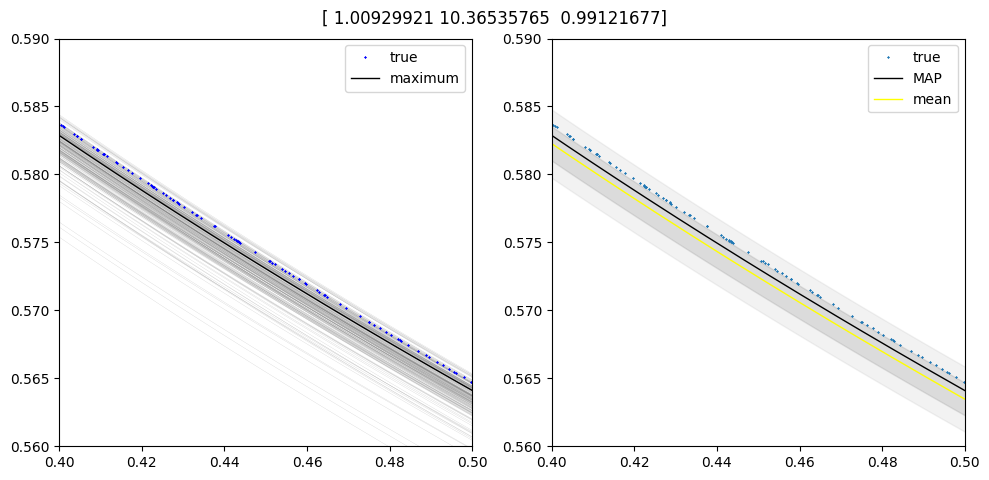

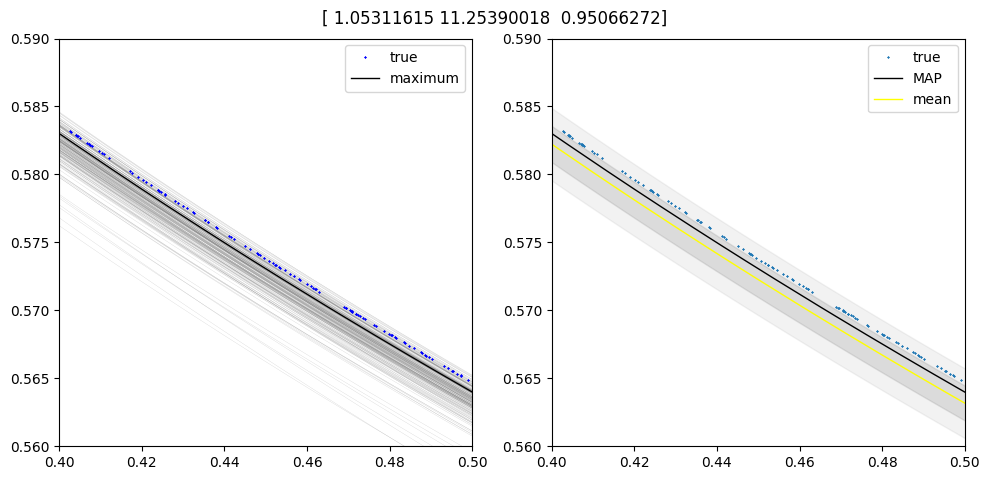

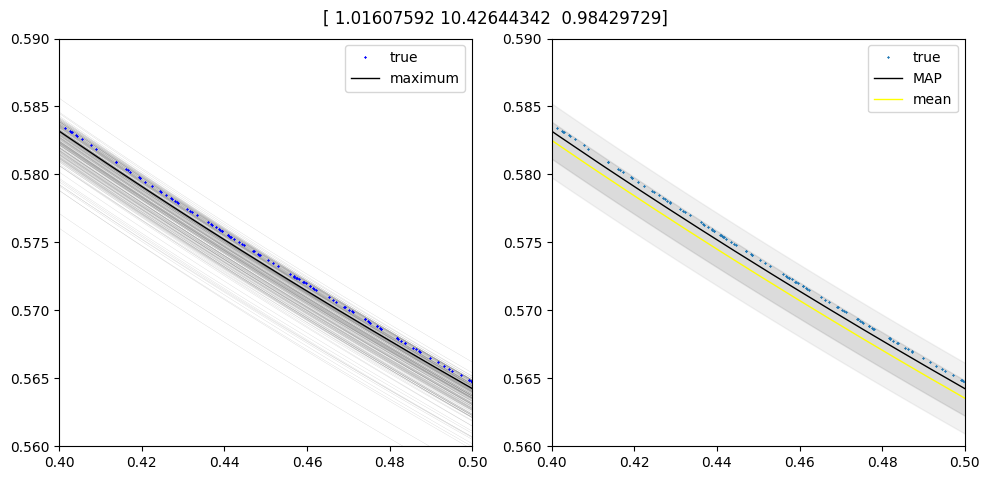

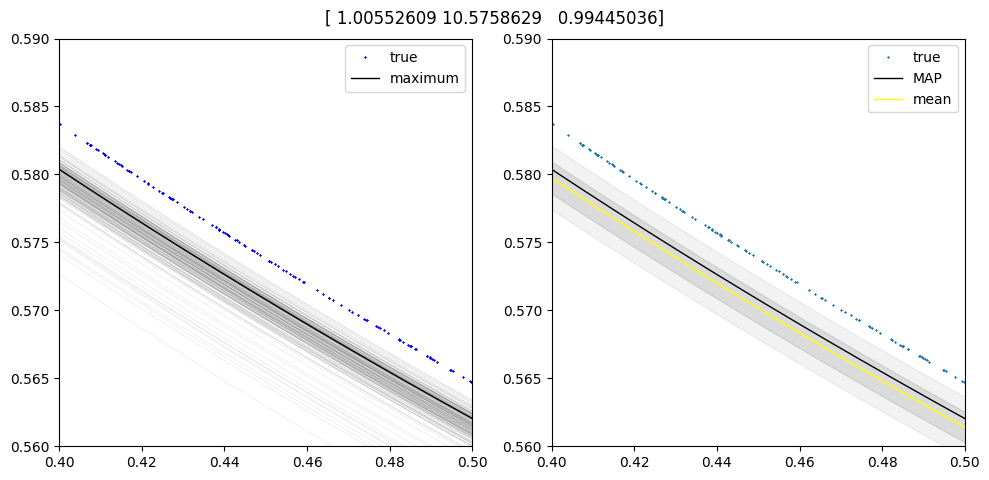

In [14]:
for j in range(10):
    X = generate_Xs(nk)
    theta_true = np.array([1, 10, 1])
    y = full.func(X, theta_true)
    theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
    from aeons.hessian import hess_autograd
    H_autograd = hess_autograd(y, full, mean_X, covinv_X, theta_max)
    cov_theta = np.linalg.inv(-H_autograd)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    xlim = (0.4, 0.5)
    ylim = (0.56, 0.59)
    for i in range(200):
        theta = np.random.multivariate_normal(theta_max, cov_theta)
        X_b = full.inverse(y, theta)
        ax1.plot(X_b, y, lw=.1, color='gray', alpha=.8)
    ax1.plot(X, y, 'x', ms=1, color='blue', label='true')
    ax1.plot(full.inverse(y, theta_max), y, lw=1, color='black', label='maximum')
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.legend();

    samples = 1000
    Xarrays = np.zeros((samples, len(y)))
    for i in range(samples):
        theta = np.random.multivariate_normal(theta_max, cov_theta)
        X_b = full.inverse(y, theta)
        Xarrays[i] = X_b
    X_std = Xarrays.T.std(axis=1)
    X_mean = Xarrays.T.mean(axis=1)

    X_b = full.inverse(y, theta_max)
    ax2.plot(X, y, 'x', ms=1, label='true')
    ax2.plot(X_b, y, lw=1, color='black', label='MAP')
    ax2.plot(X_mean, y, lw=1, color='yellow', label='mean')
    ax2.fill_betweenx(y, X_mean - 2*X_std, X_mean + 2*X_std, color='gray', alpha=0.1)
    ax2.fill_betweenx(y, X_mean - X_std, X_mean + X_std, color='gray', alpha=0.2)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.legend();
    plt.suptitle(theta_max, y=.95)
    plt.tight_layout()
    # plt.savefig(f'errorbars/{j}.png')